<a href="https://colab.research.google.com/github/samueljaval/weather-prediction/blob/main/linearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error
import datetime
import matplotlib.pyplot as plt

Let us read the csv file that we generated in the getData.ipynb portion of the project to extract the dataframe with all the data. To run this script, one must run getData.ipynb, download the csv file and import it here.

In [47]:
df = pd.read_csv('expanded_data.csv')

Let's look at the average temperature over time, which is the feature we want to predict. By highlighting the last year in our plot, we make it clear that the average temperature is cyclic and more or less repeats every year. 

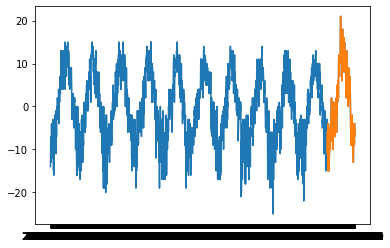

In [48]:
plt.plot(list(df['date']), list(df['avgtempC']))
plt.plot(list(df['date'].iloc[-365:]), list(df['avgtempC'].iloc[-365:])) #-365 let's us look at the last year 

Let's take advantage of what we just saw by adding a feature to our dataframe. This feature will be the number of days in the current year until a particular day. 

In [49]:
day_of_year = []
for day in df['date']:
  day = datetime.datetime.strptime(day, '%Y-%m-%d')
  day_of_year.append((day - pd.Timestamp(year=day.year, month=1, day=1)).days + 1)
df['day_of_year']=day_of_year

In [50]:
df = df.set_index('date') #just to make the dataframe cleaner
df.head()

,avgtempC,maxtempC,mintempC,totalSnow_cm,windspeedKmph,winddirDegree,precipMM,humidity,visibility,pressure,cloudcover,DewPointC,WindChillC,FeelsLikeC,avgtempC(-1),avgtempC(-2),avgtempC(-3),maxtempC(-1),maxtempC(-2),maxtempC(-3),mintempC(-1),mintempC(-2),mintempC(-3),totalSnow_cm(-1),totalSnow_cm(-2),totalSnow_cm(-3),windspeedKmph(-1),windspeedKmph(-2),windspeedKmph(-3),winddirDegree(-1),winddirDegree(-2),winddirDegree(-3),precipMM(-1),precipMM(-2),precipMM(-3),humidity(-1),humidity(-2),humidity(-3),visibility(-1),visibility(-2),visibility(-3),pressure(-1),pressure(-2),pressure(-3),cloudcover(-1),cloudcover(-2),cloudcover(-3),DewPointC(-1),DewPointC(-2),DewPointC(-3),WindChillC(-1),WindChillC(-2),WindChillC(-3),FeelsLikeC(-1),FeelsLikeC(-2),FeelsLikeC(-3),day_of_year
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-04,-14,-4,-24,0.0,6.83,300.88,0.0,96.42,2.42,1019.62,18.25,-14.42,-18.29,-18.29,-13.0,-14.0,-9.0,-7.0,-3.0,-3.0,-20.0,-22.0,-21.0,0.2,0.0,0.9,6.75,4.04,7.17,115.92,259.29,226.71,0.0,0.0,1.0,98.38,97.71,97.29,1.67,1.42,2.25,1021.46,1021.12,1025.17,61.67,15.62,37.96,-13.38,-14.21,-9.58,-16.83,-15.62,-11.79,-16.83,-15.62,-11.79,4
2009-01-05,-13,-8,-18,0.0,7.88,305.08,0.0,93.62,5.75,1015.38,58.50,-14.00,-18.12,-18.12,-14.0,-13.0,-14.0,-4.0,-7.0,-3.0,-24.0,-20.0,-22.0,0.0,0.2,0.0,6.83,6.75,4.04,300.88,115.92,259.29,0.0,0.0,0.0,96.42,98.38,97.71,2.42,1.67,1.42,1019.62,1021.46,1021.12,18.25,61.67,15.62,-14.42,-13.38,-14.21,-18.29,-16.83,-15.62,-18.29,-16.83,-15.62,5
2009-01-06,-12,-10,-15,2.7,9.08,114.67,3.1,98.00,3.46,1015.04,93.17,-11.71,-16.75,-16.75,-13.0,-14.0,-13.0,-8.0,-4.0,-7.0,-18.0,-24.0,-20.0,0.0,0.0,0.2,7.88,6.83,6.75,305.08,300.88,115.92,0.0,0.0,0.0,93.62,96.42,98.38,5.75,2.42,1.67,1015.38,1019.62,1021.46,58.50,18.25,61.67,-14.00,-14.42,-13.38,-18.12,-18.29,-16.83,-18.12,-18.29,-16.83,6
2009-01-07,-9,-7,-10,5.1,14.17,99.25,5.9,99.00,5.17,1014.83,100.00,-8.58,-14.50,-14.50,-12.0,-13.0,-14.0,-10.0,-8.0,-4.0,-15.0,-18.0,-24.0,2.7,0.0,0.0,9.08,7.88,6.83,114.67,305.08,300.88,3.1,0.0,0.0,98.00,93.62,96.42,3.46,5.75,2.42,1015.04,1015.38,1019.62,93.17,58.50,18.25,-11.71,-14.00,-14.42,-16.75,-18.12,-18.29,-16.75,-18.12,-18.29,7
2009-01-08,-7,-6,-9,1.8,12.54,118.88,2.0,99.00,4.71,1022.17,100.00,-7.04,-12.29,-12.29,-9.0,-12.0,-13.0,-7.0,-10.0,-8.0,-10.0,-15.0,-18.0,5.1,2.7,0.0,14.17,9.08,7.88,99.25,114.67,305.08,5.9,3.1,0.0,99.00,98.00,93.62,5.17,3.46,5.75,1014.83,1015.04,1015.38,100.00,93.17,58.50,-8.58,-11.71,-14.00,-14.50,-16.75,-18.12,-14.50,-16.75,-18.12,8


This 'to_predict' variable represents the feature we want to predict. The code os structure in a way that if we want to predict something else then we can just change the value of that variable.

In [51]:
to_predict = 'avgtempC'

Here we select features based on the pearson correlation values between avgtempC and all the other features. We keep a feature if the absolute value of the pearson correlation value is above 0.2. A negative value refers to a negative correlation and a postive value refers to a postive correlation, which is why we look at the absolute value. 

We will also create a new dataframe that only keeps the values from the previous days since we want to be predicting the average temperature for a particular day without knowing anything from that day. That's what we are doing when we use the filter function to only keep column names that have a '('.

In [52]:
features_of_interest = []
corr = df.corr()[[to_predict]].sort_values(to_predict)
for index in corr.index:
  if corr[to_predict][index] > 0.2 or corr[to_predict][index] < -0.2:
    features_of_interest.append(index)
features_of_interest = list(filter(lambda x : x[-1]==')',features_of_interest))
print(features_of_interest)

reduced_df = df[features_of_interest]

['humidity(-1)', 'humidity(-2)', 'humidity(-3)', 'windspeedKmph(-1)', 'windspeedKmph(-2)', 'cloudcover(-2)', 'cloudcover(-1)', 'windspeedKmph(-3)', 'cloudcover(-3)', 'visibility(-3)', 'visibility(-2)', 'visibility(-1)', 'mintempC(-3)', 'DewPointC(-3)', 'mintempC(-2)', 'DewPointC(-2)', 'mintempC(-1)', 'maxtempC(-3)', 'WindChillC(-3)', 'FeelsLikeC(-3)', 'DewPointC(-1)', 'avgtempC(-3)', 'maxtempC(-2)', 'WindChillC(-2)', 'FeelsLikeC(-2)', 'avgtempC(-2)', 'maxtempC(-1)', 'WindChillC(-1)', 'avgtempC(-1)', 'FeelsLikeC(-1)']


In [53]:
reduced_df.head()

,humidity(-1),humidity(-2),humidity(-3),windspeedKmph(-1),windspeedKmph(-2),cloudcover(-2),cloudcover(-1),windspeedKmph(-3),cloudcover(-3),visibility(-3),visibility(-2),visibility(-1),mintempC(-3),DewPointC(-3),mintempC(-2),DewPointC(-2),mintempC(-1),maxtempC(-3),WindChillC(-3),FeelsLikeC(-3),DewPointC(-1),avgtempC(-3),maxtempC(-2),WindChillC(-2),FeelsLikeC(-2),avgtempC(-2),maxtempC(-1),WindChillC(-1),avgtempC(-1),FeelsLikeC(-1)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-04,98.38,97.71,97.29,6.75,4.04,15.62,61.67,7.17,37.96,2.25,1.42,1.67,-21.0,-9.58,-22.0,-14.21,-20.0,-3.0,-11.79,-11.79,-13.38,-9.0,-3.0,-15.62,-15.62,-14.0,-7.0,-16.83,-13.0,-16.83
2009-01-05,96.42,98.38,97.71,6.83,6.75,61.67,18.25,4.04,15.62,1.42,1.67,2.42,-22.0,-14.21,-20.0,-13.38,-24.0,-3.0,-15.62,-15.62,-14.42,-14.0,-7.0,-16.83,-16.83,-13.0,-4.0,-18.29,-14.0,-18.29
2009-01-06,93.62,96.42,98.38,7.88,6.83,18.25,58.50,6.75,61.67,1.67,2.42,5.75,-20.0,-13.38,-24.0,-14.42,-18.0,-7.0,-16.83,-16.83,-14.00,-13.0,-4.0,-18.29,-18.29,-14.0,-8.0,-18.12,-13.0,-18.12
2009-01-07,98.00,93.62,96.42,9.08,7.88,58.50,93.17,6.83,18.25,2.42,5.75,3.46,-24.0,-14.42,-18.0,-14.00,-15.0,-4.0,-18.29,-18.29,-11.71,-14.0,-8.0,-18.12,-18.12,-13.0,-10.0,-16.75,-12.0,-16.75
2009-01-08,99.00,98.00,93.62,14.17,9.08,93.17,100.00,7.88,58.50,5.75,3.46,5.17,-18.0,-14.00,-15.0,-11.71,-10.0,-8.0,-18.12,-18.12,-8.58,-13.0,-10.0,-16.75,-16.75,-12.0,-7.0,-14.50,-9.0,-14.50


We now proceed to seprating the feature we want to predict from the features we use to make our prediction. We have the average temperature in the $y$ dataframe and the other features in the $X$ dataframe. This is the widely used convetion when doing this kind of seperation. 

In [54]:
no_to_predict = features_of_interest.copy()
y = df[to_predict]
X = reduced_df[no_to_predict] 

Let's split the $X$ and $y$ dataframes into test and train sets. We use 80% of the data for training and 20% for testing. We use a built in sklearn function for that and the parameter 'random_state' is just for reproducibility since the dataset is being shuffled.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

This is the core of this script, using scikit leanrn's linear regressor. The fit function will train the model with the traning set and the predict function will test the model with the testing set.

In [81]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)

Let's have a quick look at some of the prediction we made on the testing set by comparing them to the actual value.

In [82]:
df2 = pd.DataFrame({'real temp (°C)': y_test, 'predicted tem (°C)': preds})

In [83]:
df2.head()

,real temp (°C),predicted tem (°C)
date,,
2019-07-08,13,12.307480
2017-04-22,-3,-5.274142
2017-06-28,6,8.698783
2010-03-26,-1,-1.028636
2018-10-14,2,3.845173


In [75]:
df2.describe()

,real temp (°C),predicted tem (°C)
count,803.000000,803.000000
mean,-0.246575,-0.198563
std,7.929803,7.449193
min,-21.000000,-21.152417
25%,-6.000000,-5.922313
50%,-1.000000,-0.581652
75%,6.000000,5.983394
max,20.000000,17.283453


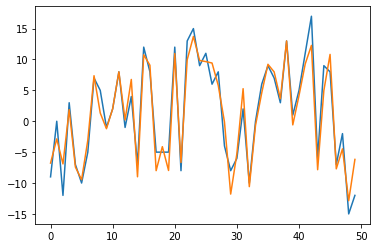

In [84]:
plt.plot(list(y_test)[-50:]) #the last 50 entries in the testing set
plt.plot(list(preds)[-50:])

We can get an even better sense for how good our model is performing by using scikit learn's score and mean_absolute error function. 

In [59]:
print(f'accuracy = {str(regressor.score(X_test, y_test)*100)[0:5]}%')
print(f'mean absolute error = {str(mean_absolute_error(y_test, prediction))[0:5]}°C')

accuracy = 92.25%
mean absolute error = 1.676°C
